In [3]:
import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import welch
import pandas as pd

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal as sig
from sklearn.preprocessing import MinMaxScaler


directory = r'C:\Users\Usuario\Desktop\Audios Control\ANEaudios'

wav_files = [f for f in os.listdir(directory) if f.endswith('.wav')]


spectra = []


for wav_file in wav_files:
 
    sample_rate, data = wavfile.read(os.path.join(directory, wav_file))
    

    if len(data.shape) > 1:
        data = data[:, 0]
    

    freqs, psd = welch(data, sample_rate)
    
    spectra.append((wav_file, freqs, psd))


spectra_array = np.array(spectra, dtype=object)

print(spectra_array)


np.savetxt('spectra_array.csv', spectra_array, delimiter=',', fmt='%s')

# Create a new DataFrame with columns 'audio_name' and 'psd'
df = pd.DataFrame({'audio_name': [spectrum[0] for spectrum in spectra_array],
                   'psd': [spectrum[2] for spectrum in spectra_array]})

# Save the DataFrame to a CSV file
df.to_csv('psd_data.csv', index=False)





[['100.0_0_.wav'
  array([    0.      ,   172.265625,   344.53125 ,   516.796875,
           689.0625  ,   861.328125,  1033.59375 ,  1205.859375,
          1378.125   ,  1550.390625,  1722.65625 ,  1894.921875,
          2067.1875  ,  2239.453125,  2411.71875 ,  2583.984375,
          2756.25    ,  2928.515625,  3100.78125 ,  3273.046875,
          3445.3125  ,  3617.578125,  3789.84375 ,  3962.109375,
          4134.375   ,  4306.640625,  4478.90625 ,  4651.171875,
          4823.4375  ,  4995.703125,  5167.96875 ,  5340.234375,
          5512.5     ,  5684.765625,  5857.03125 ,  6029.296875,
          6201.5625  ,  6373.828125,  6546.09375 ,  6718.359375,
          6890.625   ,  7062.890625,  7235.15625 ,  7407.421875,
          7579.6875  ,  7751.953125,  7924.21875 ,  8096.484375,
          8268.75    ,  8441.015625,  8613.28125 ,  8785.546875,
          8957.8125  ,  9130.078125,  9302.34375 ,  9474.609375,
          9646.875   ,  9819.140625,  9991.40625 , 10163.671875,
        

In [5]:


def audio_matrix(path, scaler):
    fs_v = []
    audio_m = []

    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        
        y, sr = librosa.load(file_path, sr=None)
        y = librosa.to_mono(y)
        y = y.reshape(-1, 1)
        y = scaler.fit_transform(y)
        y = y.flatten()
        
        fs_v.append(sr)
        audio_m.append(y)

    # Calculate the average sampling frequency
    fs = np.mean(fs_v)

    # Make sure all audio arrays have the same length
    max_length = max(len(y) for y in audio_m)
    audio_m_padded = np.array([np.pad(y, (0, max_length - len(y)), 'constant') for y in audio_m])

    return audio_m_padded, fs

def welch_vector(X, fs, window, nperseg, nfft):
    return sig.welch(X, fs, window=window, nperseg=nperseg, noverlap=(nperseg//2), nfft=nfft)

def psd_matrix(audio_m, fs, window):
    M = audio_m.shape[0]
    N = audio_m.shape[1]

    psd_matrix = np.zeros((M, N))          
    for i in range(M):
        audio_v = audio_m[i]
        f, psd = welch_vector(audio_v, fs, window, (N-1), (N*2)-1)
        psd_matrix[i] = psd
    return f, psd_matrix

def audio_classif(classif, audio_m):
    N = audio_m.shape[1]

    one_count = np.sum(classif)
    zero_count = len(classif) - one_count

    audio_one_m = np.zeros((one_count, N))
    audio_zero_m = np.zeros((zero_count, N))

    audio_one_m = audio_m[classif == 1]
    audio_zero_m = audio_m[classif == 0]

    return audio_one_m, audio_zero_m

def firwin_filter(signal, lowcut, highcut, numtaps, fs): #FIR Filter

    filter_coeficients = sig.firwin(numtaps, [lowcut, highcut], pass_zero=False, fs=fs)

    return sig.lfilter(filter_coeficients, 1.0, signal)

def audio_filter(audio_m, lowcut, highcut, numtaps, fs):
    M = audio_m.shape[0]
    N = audio_m.shape[1]

    filtered_signal_m = np.zeros((M, N))
    for i in range(M):
        filtered_signal_m[i] = firwin_filter(audio_m[i], lowcut, highcut, numtaps, fs)
    return filtered_signal_m

def snr(audio_ones, audio_zeros):
    signal = np.mean(audio_ones, axis=0)
    noise = np.mean(audio_zeros, axis=0)
    P_signal = np.mean(signal**2)
    P_noise = np.mean(noise**2)
    return 10 * np.log10(P_signal / P_noise)

In [7]:
from sklearn.preprocessing import MinMaxScaler
path = r'C:\Users\Usuario\Desktop\Audios Control\ANEaudios'
scaler = MinMaxScaler(feature_range=(-1, 1))
audio_m, fs = audio_matrix(path, scaler)

df = pd.read_csv('audios_labels.csv')
df.head()



,audio_name,Signal Presence/ Absence
0,88.0_0_.wav,0
1,88.0_1_.wav,0
2,88.0_2_.wav,0
3,88.0_3_.wav,0
4,88.0_4_.wav,0


In [15]:
import numpy as np
from scipy.signal import firwin, lfilter

# Definir la función de filtro de audio
def audio_filter(audio, low_cutoff, high_cutoff, numtaps, fs):
    # Crear el filtro de paso de banda
    taps = firwin(numtaps, [low_cutoff, high_cutoff], pass_zero=False, fs=fs)
    # Aplicar el filtro a la señal de audio
    filtered_audio = lfilter(taps, 1.0, audio)
    return filtered_audio

# Definir la función de clasificación de audio
def audio_classif(labels, audio_data):
    not_signals = audio_data[labels == 0]
    yes_signals = audio_data[labels == 1]
    return not_signals, yes_signals

# Parámetros del filtro
fq_low_cut_off = 30
fq_high_cut_off = 15000
beat_numtaps = 301
fs = 44100  # Frecuencia de muestreo (ajusta según tus datos)

# Supongamos que audio_m es tu matriz de datos de audio
# Aquí deberías cargar tus datos de audio en audio_m
# Por ejemplo, podrías usar scipy.io.wavfile.read para leer archivos .wav

# Filtrar el audio
filtered_audio_m = audio_filter(audio_m, fq_low_cut_off, fq_high_cut_off, beat_numtaps, fs)

# Crear el vector de tiempo
t = np.linspace(0, filtered_audio_m.shape[1] / fs, num=filtered_audio_m.shape[1])

# Supongamos que df es tu DataFrame que contiene las etiquetas
# Aquí deberías cargar tus etiquetas en df
# Por ejemplo, podrías usar pandas.read_csv para leer un archivo CSV

# Convertir las etiquetas a un array de numpy
label_audio = df['Signal  Presence/ Absence'].to_numpy()

# Clasificar el audio según las etiquetas
not_signals, yes_signals = audio_classif(label_audio, filtered_audio_m)

Text(0.5, 0, 'Tiempo [s]')

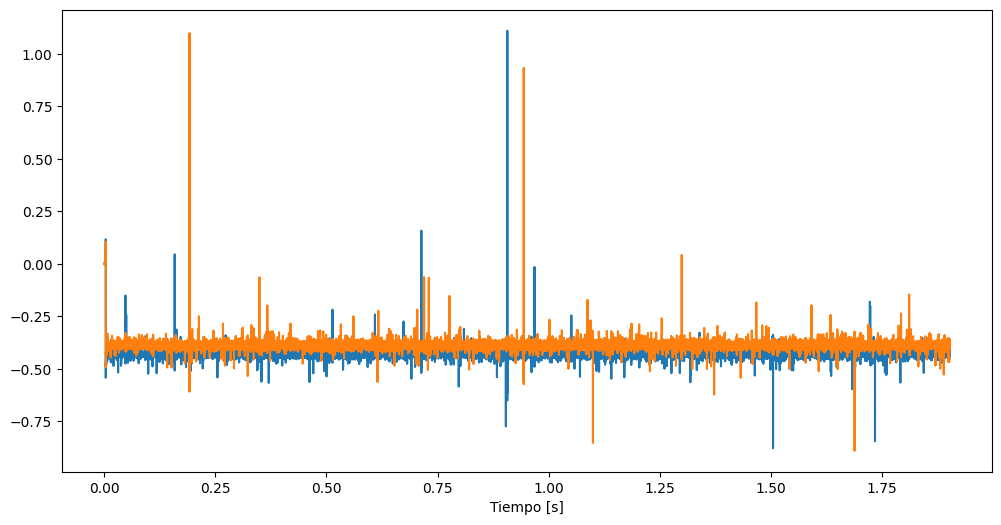

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(t, filtered_audio_m[0], label='Audio original')
plt.plot(t, filtered_audio_m[1], label='Audio filtrado')
plt.xlabel('Tiempo [s]')


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import scipy.signal as sig
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Definir la función para cargar y escalar los audios
def audio_matrix(path, scaler):
    fs_v = []
    audio_m = []

    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        y, sr = librosa.load(file_path, sr=None)
        y = librosa.to_mono(y)
        y = y.reshape(-1, 1)
        y = scaler.fit_transform(y)
        y = y.flatten()
        fs_v.append(sr)
        audio_m.append(y)

    # Calcular la frecuencia de muestreo promedio
    fs = np.mean(fs_v)

    # Asegurarse de que todos los arreglos de audio tengan la misma longitud
    max_length = max(len(y) for y in audio_m)
    audio_m_padded = np.array([np.pad(y, (0, max_length - len(y)), 'constant') for y in audio_m])

    return audio_m_padded, fs

# Definir la función para calcular la PSD utilizando el método de Welch
def welch_vector(X, fs, window, nperseg, nfft):
    return sig.welch(X, fs, window=window, nperseg=nperseg, noverlap=(nperseg//2), nfft=nfft)

def psd_matrix(audio_m, fs, window):
    M = audio_m.shape[0]
    N = audio_m.shape[1]
    psd_matrix = np.zeros((M, N))
    for i in range(M):
        audio_v = audio_m[i]
        f, psd = welch_vector(audio_v, fs, window, (N-1), (N*2)-1)
        psd_matrix[i] = psd
    return f, psd_matrix

# Definir la función para clasificar los audios
def audio_classif(classif, audio_m):
    N = audio_m.shape[1]
    one_count = np.sum(classif)
    zero_count = len(classif) - one_count
    audio_one_m = audio_m[classif == 1]
    audio_zero_m = audio_m[classif == 0]
    return audio_one_m, audio_zero_m

# Definir la función para aplicar el filtro FIR
def firwin_filter(signal, lowcut, highcut, numtaps, fs):
    filter_coeficients = sig.firwin(numtaps, [lowcut, highcut], pass_zero=False, fs=fs)
    return sig.lfilter(filter_coeficients, 1.0, signal)

def audio_filter(audio_m, lowcut, highcut, numtaps, fs):
    M = audio_m.shape[0]
    N = audio_m.shape[1]
    filtered_signal_m = np.zeros((M, N))
    for i in range(M):
        filtered_signal_m[i] = firwin_filter(audio_m[i], lowcut, highcut, numtaps, fs)
    return filtered_signal_m

# Definir la función para calcular la relación señal/ruido
def snr(audio_ones, audio_zeros):
    signal = np.mean(audio_ones, axis=0)
    noise = np.mean(audio_zeros, axis=0)
    P_signal = np.mean(signal**2)
    P_noise = np.mean(noise**2)
    return 10 * np.log10(P_signal / P_noise)

# Parámetros del filtro
fq_low_cut_off = 30
fq_high_cut_off = 15000
beat_numtaps = 301

# Cargar y escalar los audios
scaler = StandardScaler()
audio_m, fs = audio_matrix(r'C:\Users\Usuario\Desktop\Audios Control\ANEaudios', scaler)

# Filtrar los audios
filtered_audio_m = audio_filter(audio_m, fq_low_cut_off, fq_high_cut_off, beat_numtaps, fs)

# Cargar las etiquetas
labels_df = pd.read_csv('audios_labels.csv')
label_audio = labels_df['Signal  Presence/ Absence'].to_numpy()

# Clasificar los audios
not_signals, yes_signals = audio_classif(label_audio, filtered_audio_m)

# Calcular la PSD para cada grupo de señales
f, psd_ones = psd_matrix(yes_signals, fs, 'blackmanharris')
f, psd_zeros = psd_matrix(not_signals, fs, 'blackmanharris')

# Calcular el promedio de la PSD para cada grupo
mean_psd_ones = np.mean(psd_ones, axis=0)
mean_psd_zeros = np.mean(psd_zeros, axis=0)

# Graficar los promedios de la PSD
plt.figure(figsize=(10, 5))

# Graficar el promedio de la PSD para señales con etiqueta 1
plt.plot(f, mean_psd_ones, label='Señal Presente')

# Graficar el promedio de la PSD para señales con etiqueta 0
plt.plot(f, mean_psd_zeros, label='Señal Ausente')

plt.title('Promedio de la Densidad Espectral de Potencia por Etiquetas')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad Espectral de Potencia [V^2/Hz]')
plt.legend()
plt.grid()
plt.show()
